# Comparación de Agentes en RPS

Este cuaderno compara el desempeño de distintos agentes entrenados en el juego Piedra-Papel-Tijera (RPS).
Los agentes son:
- Fictitious Play (FP)
- Regret Matching (RM)
- Q-Learning Independiente (IQL)
- Joint-Action Learning con Modelado de Agente (JAL-AM)
- Agente Aleatorio (como línea base)

Cargaremos los modelos pre-entrenados de cada agente (cuando corresponda) y ejecutaremos una serie de enfrentamientos entre distintas parejas de agentes.

## 1. Importaciones y configuración
Importar librerías necesarias y preparar el entorno de juego.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import sys

# Add project root to sys.path to allow importing custom modules
module_path = os.path.abspath(os.path.join('..', 'Simultaneous Games')) # Adjust if notebook is in a different subfolder
if module_path not in sys.path:
    sys.path.append(module_path)

from games.rps import RPS
from agents.fictitiousplay_t import FictitiousPlay
from agents.regretmatching_t import RegretMatching
from agents.iql_agent import IQLAgent, IQLAgentConfig
from agents.jal_am_agent import JointActionLearningAgentModellingAgent
from agents.random_agent import RandomAgent
from base.game import SimultaneousGame, AgentID, ActionDict

## 2. Cargar entorno del juego RPS

In [2]:
game = RPS()
print("RPS game loaded.")
print("Agents:", game.agents)
print("Action spaces:", game.action_spaces)

RPS game loaded.
Agents: ['agent_0', 'agent_1']
Action spaces: {'agent_0': Discrete(3), 'agent_1': Discrete(3)}


## 3. Funciones auxiliares para cargar agentes entrenados

Definimos funciones para cargar el estado guardado de nuestros agentes entrenados.
Los scripts de entrenamiento guardan datos específicos (por ejemplo, conteos para FP, políticas para RM, tablas Q para IQL) en archivos `.pkl`.

In [ ]:
def load_fp_agent(game_instance: SimultaneousGame, agent_id: AgentID, game_name: str, agent_idx: int):
    agent = FictitiousPlay(game=game_instance, agent=agent_id)
    counts_path = os.path.join('fp_trainings', game_name, f'agent_{agent_idx}_fp_counts.pkl')
    if os.path.exists(counts_path):
        with open(counts_path, 'rb') as f:
            loaded_counts = pickle.load(f)
            # FP agent's __init__ initializes self.count and self.learned_policy
            # We need to correctly re-assign the loaded counts and update the policy
            agent.count = loaded_counts
            for ag, ct_array in agent.count.items():
                sum_counts = np.sum(ct_array)
                if sum_counts == 0:
                    agent.learned_policy[ag] = np.ones(game_instance.action_spaces[ag].n) / game_instance.action_spaces[ag].n
                else:
                    agent.learned_policy[ag] = ct_array / sum_counts
        print(f"Loaded Fictitious Play agent {agent_id} for {game_name} from {counts_path}")
    else:
        print(f"Warning: No saved counts found for FP agent {agent_id} at {counts_path}. Using fresh agent.")
    return agent

def load_rm_agent(game_instance: SimultaneousGame, agent_id: AgentID, game_name: str, agent_idx: int):
    agent = RegretMatching(game=game_instance, agent=agent_id)
    policy_path = os.path.join('rm_trainings', game_name, f'agent_{agent_idx}_rm_policy.pkl')
    if os.path.exists(policy_path):
        with open(policy_path, 'rb') as f:
            # RM saves the learned_policy directly
            agent.learned_policy = pickle.load(f)
            # RM's action selection depends on curr_policy derived from regrets,
            # but for evaluation, using the learned_policy (average strategy) is common.
            # We might need to adjust how RM makes decisions if it's purely based on current regrets.
            # For now, let's assume we want it to play according to its average learned strategy.
            # The RegretMatching class might need a method to set its strategy or use the learned_policy.
            # The current RM.action() uses curr_policy which is based on positive regrets.
            # For evaluation, we often use the average strategy.
            # Let's ensure the agent uses this loaded policy.
            # A simple way is to make its curr_policy reflect the learned_policy if it's deterministic,
            # or if action() can be made to use learned_policy.
            # For now, we assume the loaded policy is what it should play.
            # The `policy()` method returns `self.learned_policy`, so this should be fine for evaluation.
        print(f"Loaded Regret Matching agent {agent_id} for {game_name} from {policy_path}")
    else:
        print(f"Warning: No saved policy found for RM agent {agent_id} at {policy_path}. Using fresh agent.")
    return agent

def load_iql_agent(game_instance: SimultaneousGame, agent_id: AgentID, game_name: str, agent_idx: int, config: IQLAgentConfig = None):
    if config is None:
        config = IQLAgentConfig(epsilon=0.0) # Set epsilon to 0 for evaluation (greedy policy)
    agent = IQLAgent(game=game_instance, agent=agent_id, config=config)
    q_table_path = os.path.join('iql_trainings', game_name, f'agent_{agent_idx}_q_table.pkl')
    if os.path.exists(q_table_path):
        with open(q_table_path, 'rb') as f:
            agent.Q = pickle.load(f)
        print(f"Loaded IQL agent {agent_id} for {game_name} from {q_table_path}")
    else:
        print(f"Warning: No saved Q-table found for IQL agent {agent_id} at {q_table_path}. Using fresh agent.")
    agent.epsilon = 0 # Ensure greedy policy for evaluation
    return agent

def load_jalam_agent(game_instance: SimultaneousGame, agent_id: AgentID, game_name: str, agent_idx: int):
    # JALAM training notebook saves the whole agent object.
    # However, the file structure shows `training_rewards_jalam.pkl` but not agent objects.
    # Let's assume for now it saves Q-tables or similar, like IQL.
    # If it saves the whole agent, the loading mechanism would be simpler: pickle.load(f)
    # The JALAMAgent_Training.ipynb needs to be checked for how it saves.
    # For now, let's assume a similar structure to IQL for Q-table saving.
    # Path: jalam_trainings/RPS/agent_0_jalam_q_table.pkl (hypothetical)

    # Based on JALAMAgent_Training.ipynb, it seems to save the Q table and counts.
    # Let's assume a path like: jalam_trainings/RPS/agent_0_jalam_data.pkl which is a dict
    # {'Q': Q_table, 'opp_count': opp_count, 'joint_count': joint_count}

    agent = JointActionLearningAgentModellingAgent(game=game_instance, agent=agent_id, epsilon=0.0) # Epsilon = 0 for eval
    data_path = os.path.join('jalam_trainings', game_name, f'agent_{agent_idx}_jalam_model.pkl') # Ruta según JALAMAgent_Training.ipynb

    if os.path.exists(data_path):
        with open(data_path, 'rb') as f:
            saved_data = pickle.load(f)
            # Según JALAMAgent_Training.ipynb, guarda como 'Q_table' y 'model_counts'
            if 'Q_table' in saved_data and hasattr(agent, 'Q'):
                agent.Q = saved_data['Q_table']
            if 'model_counts' in saved_data and hasattr(agent, 'model_counts'):
                agent.model_counts = saved_data['model_counts']
            # Para compatibilidad con diferentes versiones
            if 'Q' in saved_data and hasattr(agent, 'Q'):
                agent.Q = saved_data['Q']
            if 'opp_count' in saved_data and hasattr(agent, 'opp_count'):
                agent.opp_count = saved_data['opp_count']
            if 'joint_count' in saved_data and hasattr(agent, 'joint_count'):
                agent.joint_count = saved_data['joint_count']
        print(f"Loaded JAL-AM agent {agent_id} for {game_name} from {data_path}")
    else:
        print(f"Warning: No saved model found for JAL-AM agent {agent_id} at {data_path}. Using fresh agent.")
    agent.epsilon = 0 # Ensure greedy policy
    return agent


## 4. Cargar agentes entrenados para RPS

Instanciar agentes. Para los agentes entrenados, cargamos su estado guardado.
El juego es RPS y los agentes son “agent_0” y “agent_1”.

In [4]:
GAME_NAME = "RPS"
agent_ids = game.agents # ["agent_0", "agent_1"]

# For simplicity in this comparison notebook, we'll load agent_0's learned models.
# In a real head-to-head, you might load agent_0 for one type and agent_1 for another,
# or ensure both agents in a pair (e.g. IQL vs IQL) are distinctly trained instances if needed.

# Fictitious Play Agent
fp_agent_0 = load_fp_agent(game, agent_ids[0], GAME_NAME, 0)
# To play FP vs FP, we'd need another instance, possibly trained independently or a copy
# fp_agent_1 = load_fp_agent(game, agent_ids[1], GAME_NAME, 1) # Assuming agent_1 was also trained

# Regret Matching Agent
rm_agent_0 = load_rm_agent(game, agent_ids[0], GAME_NAME, 0)
# rm_agent_1 = load_rm_agent(game, agent_ids[1], GAME_NAME, 1)

# IQL Agent
iql_config = IQLAgentConfig(epsilon=0.0, min_epsilon=0.0) # Ensure deterministic behavior for evaluation
iql_agent_0 = load_iql_agent(game, agent_ids[0], GAME_NAME, 0, config=iql_config)
# iql_agent_1 = load_iql_agent(game, agent_ids[1], GAME_NAME, 1, config=iql_config)

# JAL-AM Agent
# Note: The JALAMAgent_Training.ipynb needs to save its Q-table and counts for this to work.
# Assuming it saves to 'jalam_trainings/RPS/agent_0_jalam_data.pkl'
# with keys 'Q', 'opp_count', 'joint_count'
jalam_agent_0 = load_jalam_agent(game, agent_ids[0], GAME_NAME, 0)
# jalam_agent_1 = load_jalam_agent(game, agent_ids[1], GAME_NAME, 1)


# Random Agent (does not require loading)
random_agent_0 = RandomAgent(game, agent_ids[0])
random_agent_1 = RandomAgent(game, agent_ids[1])

# Store agents in a dictionary for easier access
agents_pool = {
    "FP_0": fp_agent_0,
    "RM_0": rm_agent_0,
    "IQL_0": iql_agent_0,
    "JALAM_0": jalam_agent_0, # This will be a fresh agent if loading fails
    "Random_0": random_agent_0,
    # We need second instances if we want to play e.g. FP vs Random, IQL vs Random etc.
    # Or, more flexibly, create agent instances on the fly for the second player.
    # For now, let's assume we pick one from the pool and the other is Random_1 or a copy.
}
print("\nAvailable agents for agent_0 role:", list(agents_pool.keys()))

Loaded Fictitious Play agent agent_0 for RPS from fp_trainings/RPS/agent_0_fp_counts.pkl
Loaded Regret Matching agent agent_0 for RPS from rm_trainings/RPS/agent_0_rm_policy.pkl
Loaded IQL agent agent_0 for RPS from iql_trainings/RPS/agent_0_q_table.pkl
Please ensure JAL-AM training saves 'Q', 'opp_count', and 'joint_count' to this path or update loader.

Available agents for agent_0 role: ['FP_0', 'RM_0', 'IQL_0', 'JALAM_0', 'Random_0']


## 5. Función de simulación

Función para ejecutar un enfrentamiento entre dos agentes durante una cantidad determinada de episodios.

In [ ]:
def run_match(game_instance: SimultaneousGame, agent1, agent2, num_episodes: int):
    """
    Corre un enfrentamiento entre dos agentes:
    agent1 juega como game_instance.agents[0]
    agent2 juega como game_instance.agents[1]
    """
    agent1_id = game_instance.agents[0]
    agent2_id = game_instance.agents[1]
   
    total_rewards_agent1 = 0
    total_rewards_agent2 = 0
    
    history_rewards_agent1 = []
    history_rewards_agent2 = []
   
    for episode in range(num_episodes):
        game_instance.reset()
        
        # Reiniciar al agente si tiene método reset (por ej. IQL)
        if hasattr(agent1, 'reset'):
            agent1.reset()
        if hasattr(agent2, 'reset'):
            agent2.reset()

        # En RPS el juego termina en un paso
        # Para juegos más complejos habría un bucle hasta done
        
        action1 = agent1.action()
        action2 = agent2.action()
        
        acciones = {agent1_id: action1, agent2_id: action2}
        
        obs, rewards, terminations, truncations, infos = game_instance.step(acciones)
        
        total_rewards_agent1 += rewards[agent1_id]
        total_rewards_agent2 += rewards[agent2_id]
        history_rewards_agent1.append(rewards[agent1_id])
        history_rewards_agent2.append(rewards[agent2_id])
        
        # Llamar update para agentes que aprenden online
        if hasattr(agent1, 'update'):
            agent1.update()
        if hasattr(agent2, 'update'):
            agent2.update()
   
    avg_reward_agent1 = total_rewards_agent1 / num_episodes
    avg_reward_agent2 = total_rewards_agent2 / num_episodes
    
    return {
        "avg_reward_agent1": avg_reward_agent1,
        "avg_reward_agent2": avg_reward_agent2,
        "history_agent1": history_rewards_agent1,
        "history_agent2": history_rewards_agent2,
    }
   
print("Función de simulación definida.")

Match simulation function defined.


## 6. Definir parejas de agentes y ejecutar experimentos

Configuramos las parejas de agentes que se enfrentarán entre sí.
CUIDADO: debemos instanciar correctamente al agente_1 si solo cargamos modelos de agent_0.
Para eso usamos una fábrica que genere agentes para cada rol (agent_0 o agent_1).

Let's define a helper to get an agent instance for a specific role (`agent_0` or `agent_1`).

In [ ]:
def get_agent_instance(agent_type_str: str, game_instance: SimultaneousGame, agent_id_in_game: AgentID, game_name_for_loading: str):
    """
    Crea o carga un agente para el rol agent_id_in_game.
    agent_type_str: 'FP', 'RM', 'IQL', 'JALAM', 'Random'
    agent_id_in_game: e.g., game.agents[0] o game.agents[1]
    """
    idx = game_instance.agents.index(agent_id_in_game) # 0 o 1

    if agent_type_str == "FP":
        return load_fp_agent(game_instance, agent_id_in_game, game_name_for_loading, idx)
    elif agent_type_str == "RM":
        return load_rm_agent(game_instance, agent_id_in_game, game_name_for_loading, idx)
    elif agent_type_str == "IQL":
        cfg = IQLAgentConfig(epsilon=0.0, min_epsilon=0.0) # Modo evaluación
        return load_iql_agent(game_instance, agent_id_in_game, game_name_for_loading, idx, config=cfg)
    elif agent_type_str == "JALAM":
        return load_jalam_agent(game_instance, agent_id_in_game, game_name_for_loading, idx)
    elif agent_type_str == "Random":
        return RandomAgent(game_instance, agent_id_in_game)
    else:
        raise ValueError(f"Tipo de agente desconocido: {agent_type_str}")

# Test the agent factory
print("Testing agent factory:")
test_fp_agent0 = get_agent_instance("FP", game, game.agents[0], GAME_NAME)
print(f"Created {type(test_fp_agent0).__name__} for {test_fp_agent0.agent}")
test_random_agent1 = get_agent_instance("Random", game, game.agents[1], GAME_NAME)
print(f"Created {type(test_random_agent1).__name__} for {test_random_agent1.agent}")
# This assumes saved files exist for agent_0 and agent_1 for all types if not Random.
# E.g. fp_trainings/RPS/agent_0_fp_counts.pkl AND fp_trainings/RPS/agent_1_fp_counts.pkl
# If only agent_0 is trained, then agent_1 for FP, RM, IQL, JALAM will be fresh unless handled.
# For now, the loader prints a warning if files are missing.

Testing agent factory:
Loaded Fictitious Play agent agent_0 for RPS from fp_trainings/RPS/agent_0_fp_counts.pkl
Created FictitiousPlay for agent_0
Created RandomAgent for agent_1


In [7]:
NUM_EPISODES = 1000

# Define pairings: (Agent1_Type_Str, Agent2_Type_Str)
# Agent1 will be game.agents[0], Agent2 will be game.agents[1]
pairings = [
    ("FP", "Random"),
    ("RM", "Random"),
    ("IQL", "Random"),
    ("JALAM", "Random"), # Will use fresh JALAM if agent_0_jalam_data.pkl is not found
    
    ("FP", "FP"), # Requires agent_0 and agent_1 trained models for FP
    ("IQL", "IQL"), # Requires agent_0 and agent_1 trained models for IQL
    
    ("FP", "RM"),
    ("FP", "IQL"),
    ("RM", "IQL"),
    # Add more pairings as desired, e.g., involving JALAM once its saving/loading is confirmed
    ("JALAM", "FP"),
    ("JALAM", "IQL"),
]

results = {}

print(f"Running matches for {NUM_EPISODES} episodes each...")

for p1_type, p2_type in pairings:
    print(f"\nMatch: {p1_type} (agent_0) vs {p2_type} (agent_1)")
    
    # Create a fresh game instance for each match to ensure no state leakage
    current_game = RPS() 
    agent1_id = current_game.agents[0]
    agent2_id = current_game.agents[1]

    # Instantiate agents for the match
    # The game instance passed to agents should be the one used in the match
    try:
        agent1 = get_agent_instance(p1_type, current_game, agent1_id, GAME_NAME)
        agent2 = get_agent_instance(p2_type, current_game, agent2_id, GAME_NAME)
    except Exception as e:
        print(f"Error creating agents for pairing {p1_type} vs {p2_type}: {e}")
        print("Skipping this pairing.")
        continue

    # Critical: Ensure the game object within each agent is this current_game instance
    # The get_agent_instance function already passes current_game to the agent constructor.
    # agent1.game = current_game (implicitly done if constructor assigns it)
    # agent2.game = current_game (implicitly done if constructor assigns it)

    match_key = f"{p1_type}_vs_{p2_type}"
    
    # Run the match
    # The run_match function needs to correctly use these agent instances
    # and the current_game instance.
    # The current run_match takes agent objects directly.
    match_results = run_match(current_game, agent1, agent2, NUM_EPISODES)
    
    results[match_key] = match_results
    print(f"Results for {match_key}:")
    print(f"  {p1_type} (Agent1) Avg Reward: {match_results['avg_reward_agent1']:.3f}")
    print(f"  {p2_type} (Agent2) Avg Reward: {match_results['avg_reward_agent2']:.3f}")

print("\nAll matches completed.")

Running matches for 1000 episodes each...

Match: FP (agent_0) vs Random (agent_1)
Loaded Fictitious Play agent agent_0 for RPS from fp_trainings/RPS/agent_0_fp_counts.pkl
Results for FP_vs_Random:
  FP (Agent1) Avg Reward: -0.042
  Random (Agent2) Avg Reward: 0.042

Match: RM (agent_0) vs Random (agent_1)
Loaded Regret Matching agent agent_0 for RPS from rm_trainings/RPS/agent_0_rm_policy.pkl
Results for RM_vs_Random:
  RM (Agent1) Avg Reward: -0.029
  Random (Agent2) Avg Reward: 0.029

Match: IQL (agent_0) vs Random (agent_1)
Loaded IQL agent agent_0 for RPS from iql_trainings/RPS/agent_0_q_table.pkl
Results for IQL_vs_Random:
  IQL (Agent1) Avg Reward: -0.019
  Random (Agent2) Avg Reward: 0.019

Match: JALAM (agent_0) vs Random (agent_1)
Please ensure JAL-AM training saves 'Q', 'opp_count', and 'joint_count' to this path or update loader.
Results for JALAM_vs_Random:
  JALAM (Agent1) Avg Reward: 0.007
  Random (Agent2) Avg Reward: -0.007

Match: FP (agent_0) vs FP (agent_1)
Loaded F

## 7. Analizar y visualizar resultados

In [ ]:

<VSCode.Cell language="markdown">
## 8. Análisis Detallado de Tasas de Victoria / Empate / Derrota
En esta sección calculamos para cada enfrentamiento la proporción de partidas que terminó en victoria de Agent1, victoria de Agent2 o empate.


Summary of Average Rewards (Agent1 perspective):
- FP_vs_Random: FP got -0.042, Random got 0.042
- RM_vs_Random: RM got -0.029, Random got 0.029
- IQL_vs_Random: IQL got -0.019, Random got 0.019
- JALAM_vs_Random: JALAM got 0.007, Random got -0.007
- FP_vs_FP: FP got 0.088, FP got -0.088
- IQL_vs_IQL: IQL got 0.000, IQL got 0.000
- FP_vs_RM: FP got -0.020, RM got 0.020
- FP_vs_IQL: FP got -0.243, IQL got 0.243
- RM_vs_IQL: RM got -0.017, IQL got 0.017
- JALAM_vs_FP: JALAM got 0.010, FP got -0.010
- JALAM_vs_IQL: JALAM got -0.022, IQL got 0.022


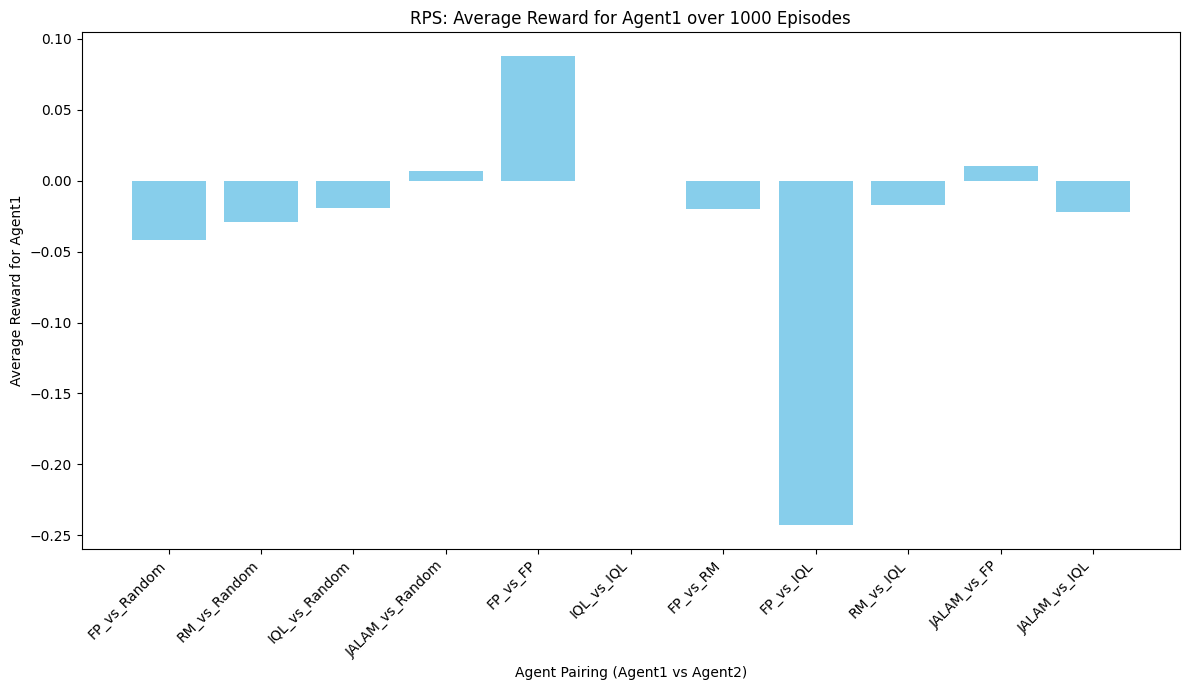


Further analysis could include win rates (if applicable), strategy profiles, etc.


In [ ]:
print("Summary of Average Rewards (Agent1 perspective):")
for match_key, res in results.items():
    p1_type, p2_type = match_key.split('_vs_')
    print(f"- {match_key}: {p1_type} got {res['avg_reward_agent1']:.3f}, {p2_type} got {res['avg_reward_agent2']:.3f}")

# Resumen de tasas de victoria, empate y derrota
for match_key, res in results.items():
    hist1 = res['history_agent1']
    hist2 = res['history_agent2']
    wins1 = sum(1 for r in hist1 if r>0)
    wins2 = sum(1 for r in hist2 if r>0)
    ties = sum(1 for r in hist1 if r==0)
    total = len(hist1)
    print(f"\nPartido {match_key}:")
    print(f"  Agent1 ganó: {wins1}/{total} ({wins1/total:.1%})")
    print(f"  Agent2 ganó: {wins2}/{total} ({wins2/total:.1%})")
    print(f"  Empates: {ties}/{total} ({ties/total:.1%})")

# Visualization: Bar chart of average rewards for Agent 1 in each pairing
fig, ax = plt.subplots(figsize=(12, 7))
match_labels = list(results.keys())
agent1_avg_rewards = [res['avg_reward_agent1'] for res in results.values()]

ax.bar(match_labels, agent1_avg_rewards, color='skyblue')
ax.set_xlabel("Agent Pairing (Agent1 vs Agent2)")
ax.set_ylabel("Average Reward for Agent1")
ax.set_title(f"RPS: Average Reward for Agent1 over {NUM_EPISODES} Episodes")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# You can add more detailed plots, e.g., cumulative rewards over episodes if needed.
# For example, plotting history_agent1 from match_results:
# selected_match_key = "FP_vs_Random" # Choose a match to plot
# if selected_match_key in results:
#     plt.figure(figsize=(10, 5))
#     cumulative_rewards_agent1 = np.cumsum(results[selected_match_key]['history_agent1'])
#     plt.plot(cumulative_rewards_agent1, label=f"{selected_match_key.split('_vs_')[0]} (Agent1)")
#     plt.xlabel("Episode")
#     plt.ylabel("Cumulative Reward")
#     plt.title(f"Cumulative Reward for Agent1 in {selected_match_key}")
#     plt.legend()
#     plt.grid(True)
#     plt.show()

print("\nFurther analysis could include win rates (if applicable), strategy profiles, etc.")